# Multiclass Text Classification: BBC News Categorization

## Overview

This notebook demonstrates a complete **multiclass text classification** pipeline. We classify BBC news articles into one of 5 categories using multiple feature engineering techniques and machine learning algorithms.

---

### What is Multiclass Classification?

Multiclass classification assigns one of **3 or more mutually exclusive classes** to each document.

| Type | Description | Example | Labels per Document |
|------|-------------|---------|--------------------|
| **Multiclass** | 3+ mutually exclusive classes | News categories | Exactly 1 |

### Pipeline

```
Raw Text → Cleaning → Preprocessing → Feature Engineering → Model Training → Evaluation
```

### Feature Methods: CountVectorizer, TF-IDF, BM25, Word2Vec
### Algorithms: Naive Bayes, Logistic Regression, SVM, Random Forest

---

In [1]:
# =============================================================================
# INSTALLATION
# =============================================================================
# Uncomment and run if packages are not installed:

# !pip install pandas numpy scikit-learn matplotlib seaborn
# !pip install nltk rank_bm25 gensim sentence-transformers
#!pip install tf-keras

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rank_bm25 import BM25Okapi
import gensim.downloader as api


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    hamming_loss, jaccard_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Download NLTK data
nltk.download('stopwords', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


---

<a id='cleaning'></a>
## 3. Data Cleaning

### Why Clean Text?

Raw text data often contains noise that doesn't contribute to classification:
- HTML tags from web scraping
- URLs and email addresses
- Excessive whitespace
- Special characters

Cleaning removes this noise to improve model performance.

### Cleaning Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Remove HTML | Strips `<tag>` elements | `<p>Hello</p>` → `Hello` |
| Remove URLs | Removes web links | `Check http://x.com` → `Check` |
| Remove Emails | Removes email addresses | `Contact a@b.com` → `Contact` |
| Normalize Whitespace | Collapses multiple spaces | `Hello    world` → `Hello world` |

In [3]:
# =============================================================================
# DATA CLEANING FUNCTION
# =============================================================================

def clean_text(text):
    """
    Clean raw text by removing noise.
    
    Steps:
        1. Remove HTML tags (e.g., <p>, <div>, <br>)
        2. Remove URLs (http://, https://, www.)
        3. Remove email addresses
        4. Normalize whitespace (multiple spaces → single space)
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Cleaned text string
    
    Example:
        >>> clean_text("<p>Visit http://example.com or email test@mail.com</p>")
        'Visit or email'
    """
    # Handle missing values
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Step 1: Remove HTML tags
    # Pattern: <anything> where anything doesn't contain >
    text = re.sub(r'<[^>]+>', '', text)
    
    # Step 2: Remove URLs
    # Pattern: http(s):// or www. followed by non-whitespace
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Step 3: Remove email addresses
    # Pattern: something@something.something
    text = re.sub(r'\S+@\S+', '', text)
    
    # Step 4: Normalize whitespace
    # Replace multiple spaces/tabs/newlines with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
# =============================================================================
# TEST CLEANING FUNCTION
# =============================================================================

# Example with various noise types
test_dirty = """
<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>
"""

print("BEFORE CLEANING:")
print("-" * 50)
print(test_dirty)
print("\nAFTER CLEANING:")
print("-" * 50)
print(clean_text(test_dirty))

BEFORE CLEANING:
--------------------------------------------------

<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>


AFTER CLEANING:
--------------------------------------------------
Hello! Check out for more info. Contact us at or visit


---

<a id='preprocessing'></a>
## 4. Text Preprocessing

### Why Preprocess?

After cleaning, we standardize the text to reduce vocabulary size and focus on meaningful words.

### Preprocessing Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Lowercasing | Converts to lowercase | `Hello WORLD` → `hello world` |
| Stopword Removal | Removes common words | `the cat is here` → `cat here` |

### What are Stopwords?

Stopwords are common words that appear frequently but carry little meaning:
- Articles: the, a, an
- Prepositions: in, on, at, to
- Conjunctions: and, but, or
- Pronouns: he, she, it, they

Removing them reduces noise and feature dimensionality.

In [5]:
# =============================================================================
# TEXT PREPROCESSING FUNCTION
# =============================================================================

# Load English stopwords once
STOP_WORDS = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess cleaned text for feature extraction.
    
    Steps:
        1. Convert to lowercase
        2. Remove stopwords
    
    Parameters:
        text (str): Cleaned text string
    
    Returns:
        str: Preprocessed text string
    
    Example:
        >>> preprocess_text("The Quick Brown Fox Jumps Over The Lazy Dog")
        'quick brown fox jumps lazy dog'
    """
    # Step 1: Convert to lowercase
    text = text.lower()
    
    # Step 2: Tokenize and remove stopwords
    tokens = text.split()
    tokens = [token for token in tokens if token not in STOP_WORDS]
    
    return ' '.join(tokens)


def full_preprocess(text):
    """
    Apply full preprocessing pipeline: cleaning + preprocessing.
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Fully preprocessed text string
    """
    return preprocess_text(clean_text(text))

In [6]:
# =============================================================================
# TEST PREPROCESSING FUNCTION
# =============================================================================

test_text = "The Quick Brown Fox Jumps Over The Lazy Dog"

print("BEFORE PREPROCESSING:")
print(f"  '{test_text}'")
print(f"  Word count: {len(test_text.split())}")

print("\nAFTER PREPROCESSING:")
processed = preprocess_text(test_text)
print(f"  '{processed}'")
print(f"  Word count: {len(processed.split())}")

print("\nSTOPWORDS REMOVED:")
removed = set(test_text.lower().split()) - set(processed.split())
print(f"  {removed}")

BEFORE PREPROCESSING:
  'The Quick Brown Fox Jumps Over The Lazy Dog'
  Word count: 9

AFTER PREPROCESSING:
  'quick brown fox jumps lazy dog'
  Word count: 6

STOPWORDS REMOVED:
  {'the', 'over'}


---

<a id='feature-engineering'></a>
## 5. Feature Engineering Methods

### Why Feature Engineering?

Machine learning algorithms require numerical input. Feature engineering converts text into numerical vectors (arrays of numbers).

### Overview of Methods

| Method | Type | Vector Size | Captures Semantics? | Speed |
|--------|------|-------------|---------------------|-------|
| CountVectorizer | Sparse | Vocabulary size | No | Fast |
| TF-IDF | Sparse | Vocabulary size | No | Fast |
| BM25 | Dense | Corpus size | No | Medium |
| Word2Vec | Dense | 300 | Yes (word-level) | Medium |

### Sparse vs Dense Vectors

- **Sparse**: Most values are zero (bag-of-words methods)
- **Dense**: Most values are non-zero (embedding methods)

### 5.1 CountVectorizer (Bag of Words)

#### How it Works

CountVectorizer converts text into a matrix of word counts:

1. Build vocabulary from all documents
2. For each document, count occurrences of each word
3. Result: Document-term matrix

#### Example

```
Documents:
  Doc1: "cat sat mat"
  Doc2: "dog sat mat"

Vocabulary: [cat, dog, mat, sat]

Matrix:
       cat  dog  mat  sat
Doc1:   1    0    1    1
Doc2:   0    1    1    1
```

#### Pros and Cons

| Pros | Cons |
|------|------|
| Simple and interpretable | Ignores word order |
| Fast computation | High dimensionality |
| Works well as baseline | No semantic meaning |

In [7]:
# =============================================================================
# COUNTVECTORIZER FUNCTIONS
# =============================================================================

def create_count_features(train_texts, test_texts, max_features=5000):
    """
    Create bag-of-words features using CountVectorizer.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted CountVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_count_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    # ngram_range=(1,2) includes unigrams and bigrams
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"CountVectorizer:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.2 TF-IDF (Term Frequency - Inverse Document Frequency)

#### How it Works

TF-IDF weighs words by importance:

- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: How rare a word is across all documents

```
TF-IDF = TF × IDF

TF = count(word in doc) / total words in doc
IDF = log(total docs / docs containing word)
```

#### Why TF-IDF?

Words that appear frequently in one document but rarely in others get higher scores:
- "Machine learning" in a tech article → High score
- "The" appearing everywhere → Low score

#### Pros and Cons

| Pros | Cons |
|------|------|
| Weighs important words | Still ignores word order |
| Reduces impact of common words | High dimensionality |
| Industry standard baseline | No semantic meaning |

In [8]:
# =============================================================================
# TF-IDF FUNCTIONS
# =============================================================================

def create_tfidf_features(train_texts, test_texts, max_features=5000):
    """
    Create TF-IDF weighted features.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted TfidfVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_tfidf_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"TF-IDF:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.3 BM25 (Best Matching 25)

#### How it Works

BM25 is a ranking function used in information retrieval. It improves on TF-IDF by:

1. **Term frequency saturation**: Diminishing returns for repeated words
2. **Document length normalization**: Longer documents don't get unfair advantage

#### Formula

```
BM25(D, Q) = Σ IDF(qi) × (f(qi, D) × (k1 + 1)) / (f(qi, D) + k1 × (1 - b + b × |D|/avgdl))

Where:
  - k1 = term frequency saturation (typically 1.2-2.0)
  - b = length normalization (typically 0.75)
  - avgdl = average document length
```

#### Usage for Classification

We use each document as a query against the corpus to create document vectors.

#### Pros and Cons

| Pros | Cons |
|------|------|
| Better than raw TF-IDF | Requires tuning k1, b |
| Handles document length | Slower than TF-IDF |
| Industry standard in search | Dense output (corpus-sized) |

In [9]:
# =============================================================================
# BM25 FUNCTIONS
# =============================================================================

def create_bm25_features(train_texts, test_texts):
    """
    Create BM25-based document similarity features.
    
    How it works:
        1. Tokenize all documents
        2. Fit BM25 on training corpus
        3. For each document, compute BM25 scores against training corpus
        4. Result: Each document represented by its similarity to training docs
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test, bm25_model)
            - X_train: Dense array of training features (n_train, n_train)
            - X_test: Dense array of test features (n_test, n_train)
            - bm25_model: Fitted BM25Okapi object
    
    Example:
        >>> X_train, X_test, bm25 = create_bm25_features(train, test)
        >>> print(X_train.shape)  # (n_train, n_train)
    """
    # Tokenize documents (BM25 expects list of token lists)
    train_tokenized = [doc.split() for doc in train_texts]
    test_tokenized = [doc.split() for doc in test_texts]
    
    # Fit BM25 on training corpus
    bm25_model = BM25Okapi(train_tokenized)
    
    # Create feature vectors
    # Each document gets scores against all training documents
    X_train = np.array([bm25_model.get_scores(doc) for doc in train_tokenized])
    X_test = np.array([bm25_model.get_scores(doc) for doc in test_tokenized])
    
    print(f"BM25:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, bm25_model

### 5.4 Word2Vec Embeddings

#### How it Works

Word2Vec learns dense vector representations of words from large text corpora:

1. Words with similar meanings have similar vectors
2. Vector arithmetic captures relationships: king - man + woman ≈ queen
3. For documents, we average word vectors

#### Pre-trained Model

We use Google's pre-trained Word2Vec model:
- Trained on Google News (~100 billion words)
- 3 million words and phrases
- 300-dimensional vectors

#### Pros and Cons

| Pros | Cons |
|------|------|
| Captures word semantics | Averaging loses word order |
| Dense, fixed-size vectors | No OOV (out-of-vocabulary) handling |
| Transfer learning from large corpus | Large model download (~1.6GB) |

In [10]:
# =============================================================================
# WORD2VEC FUNCTIONS
# =============================================================================

# Global variable to store loaded model (load once, use many times)
WORD2VEC_MODEL = None

def load_word2vec_model():
    """
    Load pre-trained Word2Vec model.
    
    Downloads Google News Word2Vec model on first call (~1.6GB).
    Subsequent calls return cached model.
    
    Returns:
        gensim.models.KeyedVectors: Pre-trained Word2Vec model
    """
    global WORD2VEC_MODEL
    if WORD2VEC_MODEL is None:
        print("Loading Word2Vec model (this may take a few minutes on first run)...")
        WORD2VEC_MODEL = api.load('word2vec-google-news-300')
        print(f"Loaded! Vocabulary size: {len(WORD2VEC_MODEL)}")
    return WORD2VEC_MODEL


def get_document_vector(text, model):
    """
    Convert document to vector by averaging word vectors.
    
    Parameters:
        text (str): Document text
        model: Word2Vec model
    
    Returns:
        numpy.ndarray: 300-dimensional document vector
    """
    words = text.split()
    
    # Get vectors for words that exist in vocabulary
    vectors = [model[word] for word in words if word in model]
    
    # Return average, or zeros if no words found
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)


def create_word2vec_features(train_texts, test_texts):
    """
    Create Word2Vec document embeddings.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test)
            - X_train: Dense array (n_train, 300)
            - X_test: Dense array (n_test, 300)
    
    Example:
        >>> X_train, X_test = create_word2vec_features(train, test)
        >>> print(X_train.shape)  # (n_train, 300)
    """
    # Load model
    model = load_word2vec_model()
    
    # Convert documents to vectors
    X_train = np.array([get_document_vector(doc, model) for doc in train_texts])
    X_test = np.array([get_document_vector(doc, model) for doc in test_texts])
    
    print(f"Word2Vec:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test

---

## Evaluation Function

### Metrics for Multiclass Classification

| Metric | Formula | Best For |
|--------|---------|----------|
| **Accuracy** | Correct / Total | Balanced classes |
| **Precision (macro)** | Average precision per class | Equal weight to each class |
| **Recall (macro)** | Average recall per class | Equal weight to each class |
| **F1-Score (macro)** | Average F1 per class | Balance of P and R across classes |

In [11]:
# =============================================================================
# EVALUATION FUNCTION (MULTICLASS)
# =============================================================================

def evaluate_multiclass(y_true, y_pred):
    """
    Evaluate multiclass classification results.
    
    Uses macro averaging (equal weight to each class).
    
    Parameters:
        y_true: True labels
        y_pred: Predicted labels
    
    Returns:
        dict: Dictionary of metrics
    """
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': f1_score(y_true, y_pred, average='macro')
    }

---

## Multiclass Classification: BBC News Categorization

**Task**: Classify news articles into one of 5 categories: business, entertainment, politics, sport, tech

**Dataset**: BBC News articles with category labels

In [12]:
# =============================================================================
# LOAD AND PREPARE BBC NEWS DATA
# =============================================================================

# Load dataset
bbc_df = pd.read_csv('Data/bbc-news-data.csv', sep='\t')

print("=" * 60)
print("BBC NEWS DATASET")
print("=" * 60)
print(f"Shape: {bbc_df.shape}")
print(f"\nClass distribution:")
print(bbc_df['category'].value_counts())

# Combine title and content
bbc_df['text'] = bbc_df['title'] + ' ' + bbc_df['content']

# Apply preprocessing
bbc_df['text_clean'] = bbc_df['text'].apply(full_preprocess)

# Train-test split
X_train_bbc, X_test_bbc, y_train_bbc, y_test_bbc = train_test_split(
    bbc_df['text_clean'],
    bbc_df['category'],
    test_size=0.2,
    random_state=42,
    stratify=bbc_df['category']
)

print(f"\nTraining samples: {len(X_train_bbc)}")
print(f"Test samples: {len(X_test_bbc)}")

BBC NEWS DATASET
Shape: (2225, 4)

Class distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Training samples: 1780
Test samples: 445


In [ ]:
# =============================================================================
# MULTICLASS: ALL FEATURE METHODS
# =============================================================================

multiclass_all_results = []

# --- CountVectorizer ---
print("\n" + "=" * 60)
print("FEATURE: CountVectorizer")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_count_features(X_train_bbc, X_test_bbc)

In [22]:
#test one
clf = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
clf.fit(X_train_feat, y_train_bbc)
y_pred = clf.predict(X_test_feat)
elapsed = time.time() - start_time
print( f"Time: {elapsed:.4f}s")
print(classification_report(y_test_bbc, y_pred))

Time: 0.0775s
               precision    recall  f1-score   support

     business       0.95      0.94      0.95       102
entertainment       0.99      0.97      0.98        77
     politics       0.90      0.94      0.92        84
        sport       1.00      0.99      1.00       102
         tech       0.96      0.95      0.96        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



In [ ]:
#test with many

for name, clf in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', LinearSVC(random_state=42, max_iter=2000)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'CountVectorizer'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))


# --- TF-IDF ---
print("\n" + "=" * 60)
print("FEATURE: TF-IDF")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_tfidf_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', LinearSVC(random_state=42, max_iter=2000)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'TF-IDF'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))

# --- BM25 ---
print("\n" + "=" * 60)
print("FEATURE: BM25")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_bm25_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', GaussianNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', SVC(kernel='linear', random_state=42)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'BM25'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))


# --- Word2Vec ---
print("\n" + "=" * 60)
print("FEATURE: Word2Vec")
print("=" * 60)
X_train_feat, X_test_feat = create_word2vec_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', GaussianNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', SVC(kernel='linear', random_state=42)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'Word2Vec'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))




FEATURE: CountVectorizer
CountVectorizer:
  Vocabulary size: 5000
  Train shape: (1780, 5000)
  Test shape: (445, 5000)
  Naive Bayes: F1 = 0.9840 | Time: 0.0177s
               precision    recall  f1-score   support

     business       0.99      0.96      0.98       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.98      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.96      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

  Logistic Regression: F1 = 0.9804 | Time: 0.3717s
               precision    recall  f1-score   support

     business       0.95      0.97      0.96       102
entertainment       0.99      1.00      0.99        77
     politics       0.99      0.95      0.97        84
        sport       0.98      1.00      0.99       102
         te

In [14]:
# =============================================================================
# MULTICLASS CLASSIFICATION SUMMARY
# =============================================================================

multiclass_df = pd.DataFrame(multiclass_all_results)

print("\n" + "=" * 70)
print("MULTICLASS CLASSIFICATION: COMPLETE RESULTS")
print("=" * 70)

# Pivot table: F1 Scores
feature_cols = [c for c in ['CountVectorizer', 'TF-IDF', 'BM25', 'Word2Vec', 'Sentence-BERT'] 
                if c in multiclass_df['Feature'].unique()]
multiclass_pivot = multiclass_df.pivot(index='Algorithm', columns='Feature', values='F1')
multiclass_pivot = multiclass_pivot[feature_cols]

print("\nF1 Scores (macro) by Algorithm and Feature Method:")
display(multiclass_pivot.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

# Pivot table: Training Time
multiclass_time_pivot = multiclass_df.pivot(index='Algorithm', columns='Feature', values='Train+Predict (s)')
multiclass_time_pivot = multiclass_time_pivot[feature_cols]

print("\n⏱ Train+Predict Time (seconds):")
display(multiclass_time_pivot.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

# Best combination
best_idx = multiclass_df['F1'].idxmax()
best = multiclass_df.loc[best_idx]
print(f"\n✓ Best combination: {best['Feature']} + {best['Algorithm']} (F1: {best['F1']:.2%})")

# Fastest
fastest_idx = multiclass_df['Train+Predict (s)'].idxmin()
fastest = multiclass_df.loc[fastest_idx]
print(f"⚡ Fastest combination: {fastest['Feature']} + {fastest['Algorithm']} ({fastest['Train+Predict (s)']:.4f}s)")





MULTICLASS CLASSIFICATION: COMPLETE RESULTS

F1 Scores (macro) by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,98.04%,99.12%,98.44%,95.92%
Naive Bayes,98.40%,98.40%,88.62%,93.08%
Random Forest,96.22%,96.65%,95.08%,95.93%
SVM,98.21%,98.89%,98.66%,96.33%



⏱ Train+Predict Time (seconds):


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,0.3717,0.1464,0.1750,0.0577
Naive Bayes,0.0177,0.0067,0.0850,0.0156
Random Forest,0.3531,0.3302,0.7259,0.3816
SVM,0.7972,0.0539,1.1832,0.1334



✓ Best combination: TF-IDF + Logistic Regression (F1: 99.12%)
⚡ Fastest combination: TF-IDF + Naive Bayes (0.0067s)


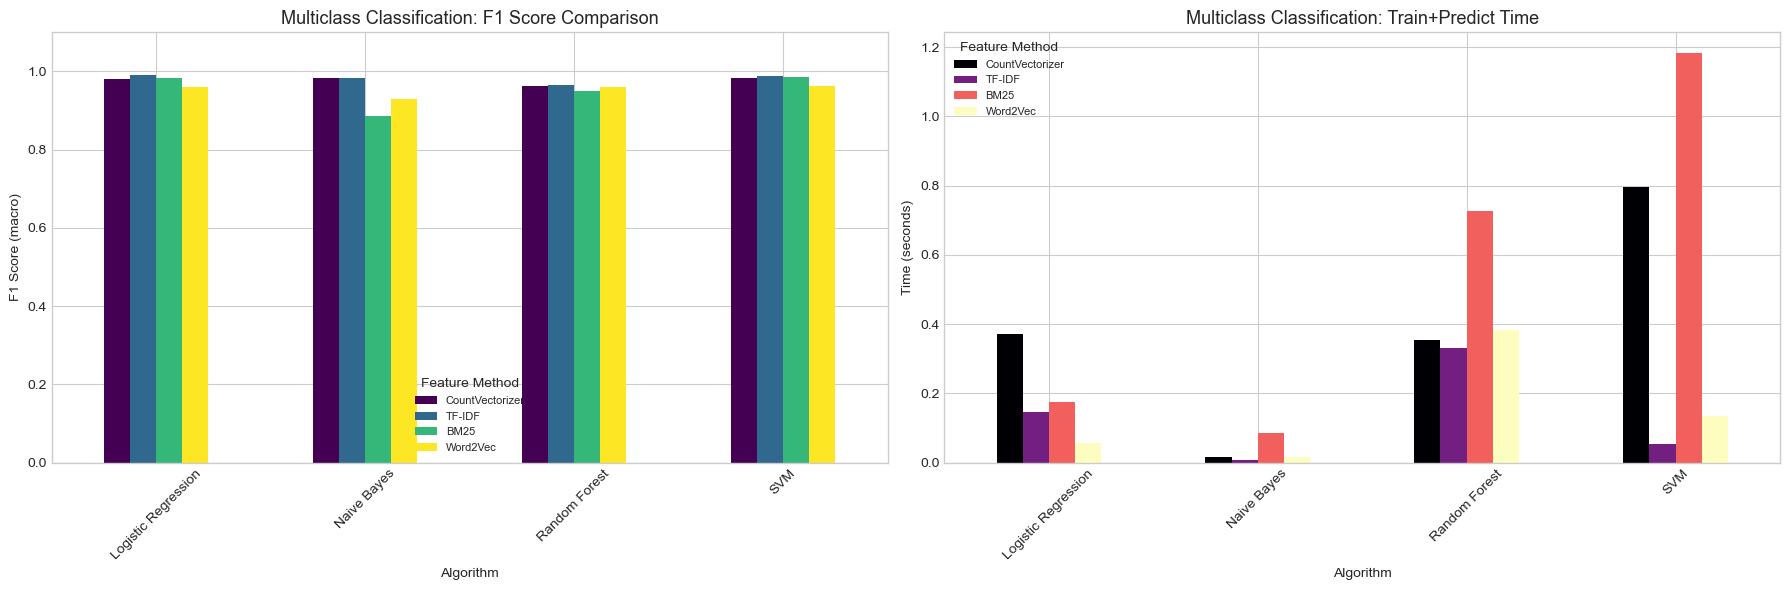

In [15]:
# Visualization: F1 Scores and Timing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score comparison
multiclass_pivot.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Multiclass Classification: F1 Score Comparison', fontsize=13)
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('F1 Score (macro)')
axes[0].legend(title='Feature Method', fontsize=8)
axes[0].set_ylim(0, 1.1)
axes[0].tick_params(axis='x', rotation=45)

# Timing comparison
multiclass_time_pivot.plot(kind='bar', ax=axes[1], colormap='magma')
axes[1].set_title('Multiclass Classification: Train+Predict Time', fontsize=13)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Time (seconds)')
axes[1].legend(title='Feature Method', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
